In [1]:
from tensorflow.keras import layers, models

def build_generator(latent_dim):
    model = models.Sequential()
    model.add(layers.Dense(128, activation='relu', input_dim=latent_dim))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dense(28*28, activation='tanh'))
    model.add(layers.Reshape((28, 28, 1)))
    return model


In [2]:
def build_discriminator(input_shape):
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=input_shape))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))  # Real or fake
    return model

In [3]:
def build_gan(generator, discriminator):
    discriminator.trainable = False  # Freeze the discriminator during GAN training
    model = models.Sequential()
    model.add(generator)
    model.add(discriminator)
    return model


In [4]:
import numpy as np
import tensorflow as tf

latent_dim = 100
image_shape = (28, 28)

# Load and normalize MNIST dataset
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = (x_train.astype(np.float32) - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=-1)

# Build and compile discriminator
discriminator = build_discriminator(image_shape)
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Build generator
generator = build_generator(latent_dim)

# Build and compile GAN
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer='adam')


In [5]:
import matplotlib.pyplot as plt

def save_generated_images(epoch, examples=10, dim=(1, 10), figsize=(10, 1)):
    noise = np.random.randn(examples, latent_dim)
    generated_images = generator.predict(noise)
    plt.figure(figsize=figsize)
    for i in range(examples):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"gan_generated_image_{epoch}.png")
    plt.close()


In [6]:
def train_gan(epochs, batch_size, sample_interval):
    half_batch = batch_size // 2

    for epoch in range(epochs):
        # Train discriminator
        idx = np.random.randint(0, x_train.shape[0], half_batch)
        real_images = x_train[idx]
        fake_images = generator.predict(np.random.randn(half_batch, latent_dim))

        # Labels for real and fake images
        real_labels = np.ones((half_batch, 1))
        fake_labels = np.zeros((half_batch, 1))

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator
        noise = np.random.randn(batch_size, latent_dim)
        valid_labels = np.ones((batch_size, 1))
        g_loss = gan.train_on_batch(noise, valid_labels)

        # Print progress and save images periodically
        if epoch % sample_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]} | D accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]")
            save_generated_images(epoch)


In [7]:
def generate_new_images(num_images=10):
    noise = np.random.randn(num_images, latent_dim)
    generated_images = generator.predict(noise)
    
    # Rescale to [0, 1] for visualization
    generated_images = (generated_images + 1) / 2.0
    
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.show()

1/1 [==============================] - 0s 404ms/step
0 [D loss: 0.7808008790016174 | D accuracy: 17.1875] [G loss: 0.7304531931877136]
1/1 [==============================] - 0s 41ms/step


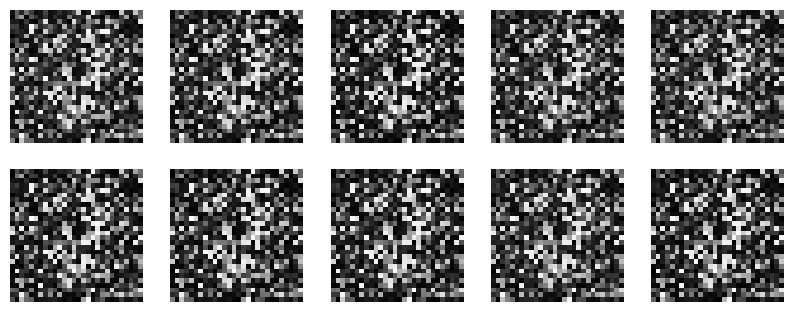

In [8]:
# Training the GAN
epochs = 5
batch_size = 64
sample_interval = 5

train_gan(epochs, batch_size, sample_interval)

# Generate new images
generate_new_images(num_images=10)
